# Wavefront Set Neural Network - U-Net Training

This notebook trains a U-Net to predict wavefront set angles from shape boundaries.

**Make sure to enable GPU:** Runtime → Change runtime type → Hardware accelerator → GPU

## 1. Install Dependencies and Setup

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import binary_erosion

# Check GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cuda
GPU: Tesla T4


## 2. Data Generation Functions

In [2]:
# Constants
K = 36  # Number of angle bins
bin_width = np.pi / K

def generate_circle_normals(H, W, seed=None):
    """Generate a circle and return angles at boundary pixels (H, W, 2)"""
    rng = np.random.default_rng(seed)
    center_x = rng.uniform(0.2 * W, 0.8 * W)
    center_y = rng.uniform(0.2 * H, 0.8 * H)
    radius = rng.uniform(0.15 * min(H, W), 0.35 * min(H, W))

    y, x = np.ogrid[:H, :W]
    mask = (x - center_x) ** 2 + (y - center_y) ** 2 <= radius ** 2

    # Detect boundary pixels
    boundary = mask & ~binary_erosion(mask)

    # Initialize with sentinel value
    angles = np.full((H, W, 2), -100.0, dtype=np.float32)

    for i in range(H):
        for j in range(W):
            if boundary[i, j]:
                dx = j - center_x
                dy = i - center_y
                length = np.sqrt(dx ** 2 + dy ** 2)
                if length > 0:
                    angle = np.arctan2(dy, dx)
                    # Store in channel 0
                    angles[i, j, 0] = angle % np.pi

    return angles, mask

def _compute_poly_normals(H, W, vertices):
    """Helper to compute mask and normals for a polygon defined by vertices."""
    from matplotlib.path import Path
    poly_path = Path(vertices)

    y, x = np.mgrid[:H, :W]
    points = np.vstack((x.ravel(), y.ravel())).T
    mask = poly_path.contains_points(points).reshape(H, W)
    boundary = mask & ~binary_erosion(mask)

    angles = np.full((H, W, 2), -100.0, dtype=np.float32)

    num_vertices = len(vertices)
    # Pre-calculate normals for all edges
    edge_normals = []
    for k in range(num_vertices):
        v1 = vertices[k]
        v2 = vertices[(k + 1) % num_vertices]
        edge_vec = v2 - v1
        edge_length = np.linalg.norm(edge_vec)
        if edge_length > 0:
            edge_dir = edge_vec / edge_length
            # Outward normal (assuming CCW winding)
            normal_vec = np.array([-edge_dir[1], edge_dir[0]])
        else:
            normal_vec = np.zeros(2)
        edge_normals.append(normal_vec)

    y_idxs, x_idxs = np.where(boundary)
    for i, j in zip(y_idxs, x_idxs):
        point = np.array([j, i])

        # Check for corner (closeness to vertex)
        dists = np.linalg.norm(vertices - point, axis=1)
        min_dist_idx = np.argmin(dists)

        if dists[min_dist_idx] < 2.0:
            # It's a corner! Get normals of adjacent edges.
            idx_prev = (min_dist_idx - 1) % num_vertices
            idx_curr = min_dist_idx

            n1 = edge_normals[idx_prev]
            n2 = edge_normals[idx_curr]

            if np.linalg.norm(n1) > 0:
                angles[i, j, 0] = np.arctan2(n1[1], n1[0]) % np.pi
            if np.linalg.norm(n2) > 0:
                angles[i, j, 1] = np.arctan2(n2[1], n2[0]) % np.pi

        else:
            # Not a corner, find single closest edge
            closest_dist = float('inf')
            closest_normal = (0, 0)

            for k in range(num_vertices):
                v1 = vertices[k]
                v2 = vertices[(k + 1) % num_vertices]
                edge_vec = v2 - v1
                edge_length = np.linalg.norm(edge_vec)
                if edge_length == 0: continue

                edge_dir = edge_vec / edge_length
                point_vec = point - v1
                proj_length = np.dot(point_vec, edge_dir)

                if proj_length < 0:
                    closest_point = v1
                elif proj_length > edge_length:
                    closest_point = v2
                else:
                    closest_point = v1 + proj_length * edge_dir

                dist = np.linalg.norm(point - closest_point)
                if dist < closest_dist:
                    closest_dist = dist
                    closest_normal = edge_normals[k]

            length = np.linalg.norm(closest_normal)
            if length > 0:
                angle = np.arctan2(closest_normal[1], closest_normal[0])
                angles[i, j, 0] = angle % np.pi

    return angles, mask

def generate_square_normals(H, W, seed=None):
    rng = np.random.default_rng(seed)
    center_x = rng.uniform(0.3 * W, 0.7 * W)
    center_y = rng.uniform(0.3 * H, 0.7 * H)
    radius = rng.uniform(0.15 * min(H, W), 0.3 * min(H, W))
    rotation = rng.uniform(0, 2 * np.pi)

    # Generate 4 vertices for a square
    angles_gen = np.linspace(0, 2 * np.pi, 4, endpoint=False) + rotation
    vertices = np.array([
        (center_x + radius * np.cos(angle), center_y + radius * np.sin(angle))
        for angle in angles_gen
    ])

    return _compute_poly_normals(H, W, vertices)

def generate_polygon_normals(H, W, num_vertices=5, seed=None):
    rng = np.random.default_rng(seed)
    center_x = rng.uniform(0.3 * W, 0.7 * W)
    center_y = rng.uniform(0.3 * H, 0.7 * H)
    radius = rng.uniform(0.2 * min(H, W), 0.4 * min(H, W))
    angles_gen = np.linspace(0, 2 * np.pi, num_vertices, endpoint=False)
    angles_gen += rng.uniform(0, 2 * np.pi / num_vertices, size=num_vertices)

    vertices = np.array([
        (center_x + radius * np.cos(angle), center_y + radius * np.sin(angle))
        for angle in angles_gen
    ])

    return _compute_poly_normals(H, W, vertices)

def generate_ellipse_normals(H, W, seed=None):
    rng = np.random.default_rng(seed)
    center_x = rng.uniform(0.2 * W, 0.8 * W)
    center_y = rng.uniform(0.2 * H, 0.8 * H)
    min_dim = min(H, W)
    a = rng.uniform(0.15 * min_dim, 0.35 * min_dim)  # Semi-major axis
    b = rng.uniform(0.15 * min_dim, 0.35 * min_dim)  # Semi-minor axis
    rotation = rng.uniform(0, 2 * np.pi)

    y, x = np.mgrid[:H, :W]

    # Transform to local coordinates centered and unrotated
    cos_r = np.cos(rotation)
    sin_r = np.sin(rotation)
    dx = x - center_x
    dy = y - center_y

    local_x = dx * cos_r + dy * sin_r
    local_y = -dx * sin_r + dy * cos_r

    mask = (local_x / a)**2 + (local_y / b)**2 <= 1
    boundary = mask & ~binary_erosion(mask)

    angles = np.full((H, W, 2), -100.0, dtype=np.float32)

    # For ellipses, normal is not just radial
    y_idxs, x_idxs = np.where(boundary)
    if len(y_idxs) > 0:
        lx = local_x[boundary]
        ly = local_y[boundary]

        # Local normal components
        nx_local = lx / (a**2)
        ny_local = ly / (b**2)

        # Rotate normal back to global coordinates
        nx = nx_local * cos_r - ny_local * sin_r
        ny = nx_local * sin_r + ny_local * cos_r

        calc_angles = np.arctan2(ny, nx)
        angles[boundary, 0] = calc_angles % np.pi

    return angles, mask

print("Data generation functions loaded!")

Data generation functions loaded!


## 3. Generate Training Data

In [3]:
import torch
import numpy as np

# Training data parameters
num_samples = 2000
H, W = 128, 128
print(f"Generating {num_samples} training samples (Circles & Squares)...")

masks = []
angles = []

for i in range(num_samples):
    if (i + 1) % 200 == 0:
        print(f"  Generated {i + 1}/{num_samples} samples")

    # Train only on Circles and Squares
    if i % 2 == 0:
        angle_map, mask = generate_circle_normals(H, W, seed=i)
    else:
        angle_map, mask = generate_square_normals(H, W, seed=i)

    masks.append(mask)
    angles.append(angle_map)

masks_tensor = torch.tensor(np.array(masks), dtype=torch.float32)
angles_tensor = torch.tensor(np.array(angles), dtype=torch.float32)

print(f"\nDataset created!")
print(f"  Samples: {len(masks)}")
print(f"  Angles shape: {angles_tensor.shape}")

Generating 2000 training samples (Circles & Squares)...
  Generated 200/2000 samples
  Generated 400/2000 samples
  Generated 600/2000 samples
  Generated 800/2000 samples
  Generated 1000/2000 samples
  Generated 1200/2000 samples
  Generated 1400/2000 samples
  Generated 1600/2000 samples
  Generated 1800/2000 samples
  Generated 2000/2000 samples

Dataset created!
  Samples: 2000
  Angles shape: torch.Size([2000, 128, 128, 2])


## 4. U-Net Model Definition

In [4]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = torch.nn.functional.pad(x1, [diffX // 2, diffX - diffX // 2,
                                          diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = nn.Conv2d(64, n_classes, kernel_size=1)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

class WavefrontUNet(nn.Module):
    def __init__(self, K=36, bilinear=False):
        super(WavefrontUNet, self).__init__()
        self.unet = UNet(n_channels=1, n_classes=K, bilinear=bilinear)
        self.K = K

    def forward(self, x):
        return self.unet(x)

print("U-Net model defined!")

U-Net model defined!


## 5. Dataset and DataLoader

In [5]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

class WavefrontDataset(Dataset):
    def __init__(self, masks, angles, K):
        self.masks = masks
        self.angles = angles
        self.K = K
        self.bin_width = np.pi / K

    def __len__(self):
        return len(self.masks)

    def __getitem__(self, idx):
        mask = self.masks[idx].unsqueeze(0)  # (1, H, W)
        angle_map = self.angles[idx]         # (H, W, 2)
        H_local, W_local, C = angle_map.shape

        # Multi-hot target: (K, H, W)
        target = torch.zeros((self.K, H_local, W_local), dtype=torch.float32)

        valid_mask = angle_map > -10.0
        boundary_mask = (valid_mask[..., 0] | valid_mask[..., 1]).float().unsqueeze(0)

        # Fill targets for both channels
        for c in range(2):
            channel_valid = valid_mask[..., c]
            if channel_valid.any():
                vals = angle_map[..., c][channel_valid]
                bins = (vals / self.bin_width).long()
                bins = torch.clamp(bins, 0, self.K - 1)
                y_idxs, x_idxs = torch.where(channel_valid)
                target[bins, y_idxs, x_idxs] = 1.0

        return mask, target, boundary_mask

# Create dataset and split
# Assumes masks_tensor, angles_tensor, and K are defined globally
try:
    dataset = WavefrontDataset(masks_tensor, angles_tensor, K)
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(
        dataset, [train_size, val_size],
        generator=torch.Generator().manual_seed(42)
    )

    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

    print(f"Train samples: {train_size}, Val samples: {val_size}")
except NameError as e:
    print(f"Error: {e}. Please run the Data Generation cell (Section 3) first.")

Train samples: 1600, Val samples: 400


## 6. Training Functions

In [6]:
def train_epoch_multilabel(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, targets, masks in dataloader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        # BCEWithLogitsLoss returns (B, K, H, W)
        loss_map = criterion(outputs, targets)
        # Mask out non-boundary pixels
        # Sum loss over all bins and all boundary pixels
        # Divide by number of boundary pixels to get average total BCE per pixel
        loss = (loss_map * masks).sum() / (masks.sum() + 1e-8)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Top-1 Accuracy Check
        # Get the predicted bin (highest logit)
        pred_bins = torch.argmax(outputs, dim=1, keepdim=True)
        # Check if the target has a 1.0 at this bin
        is_correct = torch.gather(targets, 1, pred_bins)

        # Only evaluate on boundary pixels
        boundary_mask = masks > 0
        if boundary_mask.sum() > 0:
            correct += (is_correct[boundary_mask] > 0.5).sum().item()
            total += boundary_mask.sum().item()

    accuracy = 100 * correct / total if total > 0 else 0
    return running_loss / len(dataloader), accuracy

def validate_multilabel(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, targets, masks in dataloader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            masks = masks.to(device)

            outputs = model(inputs)
            loss_map = criterion(outputs, targets)
            loss = (loss_map * masks).sum() / (masks.sum() + 1e-8)

            running_loss += loss.item()

            pred_bins = torch.argmax(outputs, dim=1, keepdim=True)
            is_correct = torch.gather(targets, 1, pred_bins)

            boundary_mask = masks > 0
            if boundary_mask.sum() > 0:
                correct += (is_correct[boundary_mask] > 0.5).sum().item()
                total += boundary_mask.sum().item()

    accuracy = 100 * correct / total if total > 0 else 0
    return running_loss / len(dataloader), accuracy

print("Training functions updated for multi-label support!")

Training functions updated for multi-label support!


## 7. Train the Model

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim

# Create model
model = WavefrontUNet(K=K, bilinear=False)
model = model.to(device)
print(f"Model: {sum(p.numel() for p in model.parameters())} parameters\n")

# Training setup for Multi-Label (BCEWithLogitsLoss)
criterion = nn.BCEWithLogitsLoss(reduction='none')
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

# Training loop
num_epochs = 30
best_val_loss = float('inf')
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

print("Starting multi-label training...\n")

for epoch in range(num_epochs):
    # Use the new multi-label training functions
    train_loss, train_acc = train_epoch_multilabel(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate_multilabel(model, val_loader, criterion, device)

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs}: "
          f"Train Loss={train_loss:.4f}, Acc={train_acc:.1f}% | "
          f"Val Loss={val_loss:.4f}, Acc={val_acc:.1f}%")

    scheduler.step(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        # Save as best_wavefront_unet.pth to update the existing file
        torch.save(model.state_dict(), 'best_wavefront_unet.pth')
        print("  ✓ Saved best model")

print(f"\nTraining complete! Best val loss: {best_val_loss:.4f}")

Model: 31038756 parameters

Starting multi-label training...

Epoch 1/30: Train Loss=4.2414, Acc=26.0% | Val Loss=2.5777, Acc=43.8%
  ✓ Saved best model
Epoch 2/30: Train Loss=2.2193, Acc=52.0% | Val Loss=2.1117, Acc=53.9%
  ✓ Saved best model
Epoch 3/30: Train Loss=1.8605, Acc=61.2% | Val Loss=1.7669, Acc=64.1%
  ✓ Saved best model
Epoch 4/30: Train Loss=1.6369, Acc=67.3% | Val Loss=1.4684, Acc=72.8%
  ✓ Saved best model
Epoch 5/30: Train Loss=1.5298, Acc=69.0% | Val Loss=1.6145, Acc=64.7%
Epoch 6/30: Train Loss=1.3885, Acc=72.7% | Val Loss=1.2604, Acc=76.4%
  ✓ Saved best model
Epoch 7/30: Train Loss=1.2997, Acc=74.0% | Val Loss=1.2590, Acc=73.9%
  ✓ Saved best model
Epoch 8/30: Train Loss=1.2323, Acc=75.3% | Val Loss=1.1017, Acc=79.3%
  ✓ Saved best model
Epoch 9/30: Train Loss=1.1469, Acc=77.2% | Val Loss=1.1088, Acc=78.9%
Epoch 10/30: Train Loss=1.0682, Acc=78.8% | Val Loss=1.0542, Acc=79.0%
  ✓ Saved best model
Epoch 11/30: Train Loss=1.1294, Acc=76.9% | Val Loss=1.0013, Acc=80.2

## 8. Plot Training History

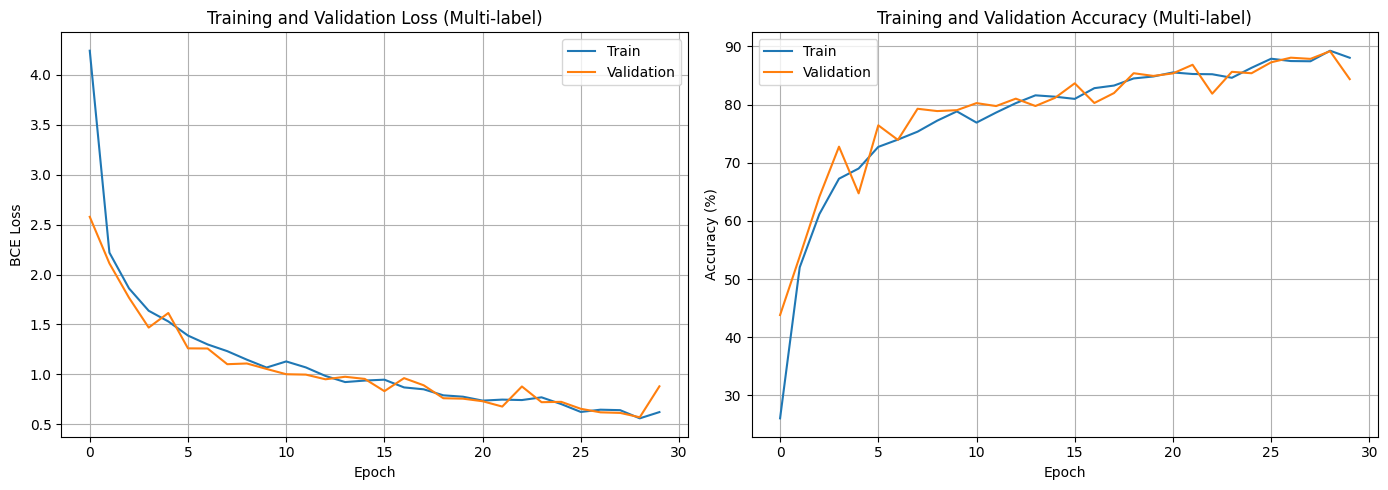

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(history['train_loss'], label='Train')
ax1.plot(history['val_loss'], label='Validation')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('BCE Loss')
ax1.set_title('Training and Validation Loss (Multi-label)')
ax1.legend()
ax1.grid(True)

ax2.plot(history['train_acc'], label='Train')
ax2.plot(history['val_acc'], label='Validation')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Training and Validation Accuracy (Multi-label)')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

## 9b. Test Predictions for Polygon

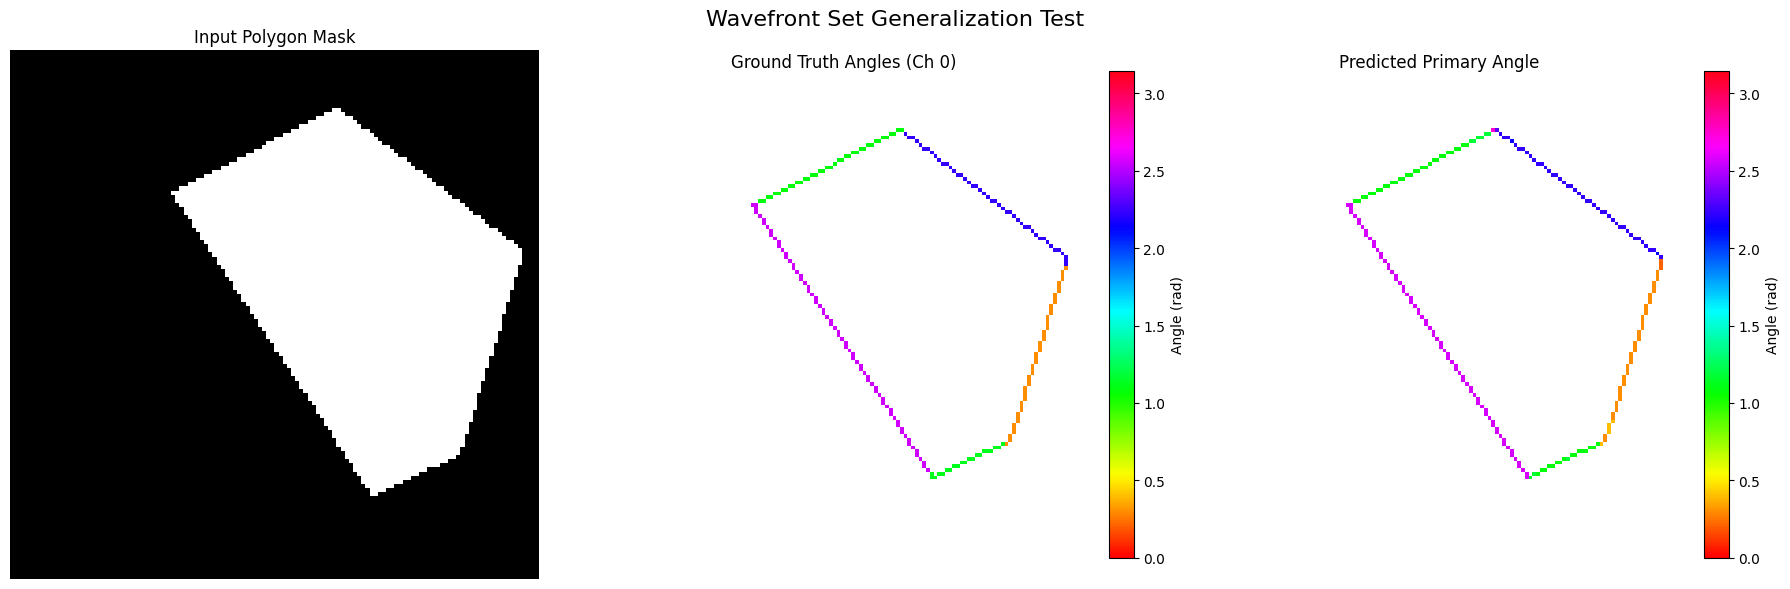


Analyzing Corner Pixel at (50, 123):
  Ground Truths: 127.7° (Bin 25) and 17.4° (Bin 3)
  Top 3 Predicted Bins: [2 3 7]
  Top 3 Probabilities:  [0.7195093  0.12713191 0.00266141]


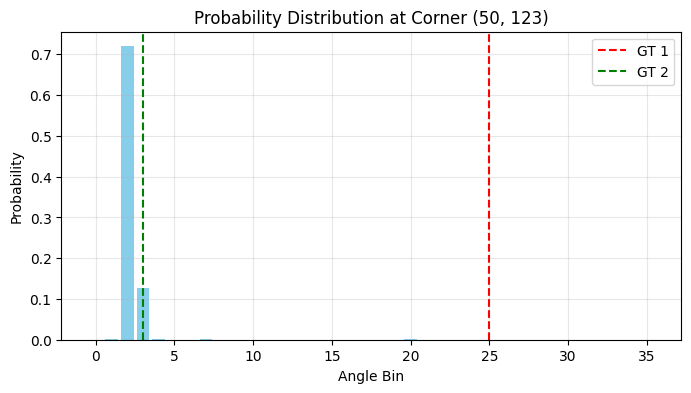

In [9]:
# Load best model
model.load_state_dict(torch.load('best_wavefront_unet.pth'))
model.eval()

# Generate test samples - Test Generalization on Polygon
# Use a seed that produces a good shape with clear corners
test_angles, test_mask = generate_polygon_normals(H, W, num_vertices=5, seed=42)

# Predict
mask_tensor = torch.tensor(test_mask, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
with torch.no_grad():
    logits = model(mask_tensor)
    probs = torch.sigmoid(logits)  # Apply Sigmoid for multi-label probabilities

probs_np = probs.squeeze(0).cpu().numpy()  # (K, H, W)

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# 1. Input
axes[0].imshow(test_mask, cmap='gray')
axes[0].set_title('Input Polygon Mask')
axes[0].axis('off')

# 2. Ground Truth (Composite of both channels)
gt_combined = np.full((H, W), -1.0)
valid_mask = test_angles[..., 0] > -10
gt_combined[valid_mask] = test_angles[..., 0][valid_mask] # Prioritize ch0 for viz

masked_gt = np.ma.masked_where(gt_combined < 0, gt_combined)
im1 = axes[1].imshow(masked_gt, cmap='hsv', vmin=0, vmax=np.pi)
axes[1].set_title('Ground Truth Angles (Ch 0)')
axes[1].axis('off')
plt.colorbar(im1, ax=axes[1], fraction=0.046, label='Angle (rad)')

# 3. Predicted "Primary" Angle (Max Probability)
pred_bins = np.argmax(probs_np, axis=0)
pred_angles_map = pred_bins * bin_width + bin_width / 2
masked_pred = np.ma.masked_where(~valid_mask, pred_angles_map)

im2 = axes[2].imshow(masked_pred, cmap='hsv', vmin=0, vmax=np.pi)
axes[2].set_title('Predicted Primary Angle')
axes[2].axis('off')
plt.colorbar(im2, ax=axes[2], fraction=0.046, label='Angle (rad)')

plt.suptitle('Wavefront Set Generalization Test', fontsize=16)
plt.tight_layout()
plt.show()

# Analyze a Corner Pixel
valid_ch0 = test_angles[..., 0] > -10
valid_ch1 = test_angles[..., 1] > -10
corner_mask = valid_ch0 & valid_ch1
corner_pixels = np.argwhere(corner_mask)

if len(corner_pixels) > 0:
    cy, cx = corner_pixels[len(corner_pixels)//2]
    print(f"\nAnalyzing Corner Pixel at ({cy}, {cx}):")

    gt_0 = test_angles[cy, cx, 0]
    gt_1 = test_angles[cy, cx, 1]
    bin_0 = int(gt_0 / bin_width)
    bin_1 = int(gt_1 / bin_width)

    # Fixed the string formatting here to remove null bytes
    print(f"  Ground Truths: {np.degrees(gt_0):.1f}\u00B0 (Bin {bin_0}) and {np.degrees(gt_1):.1f}\u00B0 (Bin {bin_1})")

    pixel_probs = probs_np[:, cy, cx]
    top_bins = np.argsort(pixel_probs)[-3:][::-1]

    print(f"  Top 3 Predicted Bins: {top_bins}")
    print(f"  Top 3 Probabilities:  {pixel_probs[top_bins]}")

    plt.figure(figsize=(8, 4))
    plt.bar(range(K), pixel_probs, color='skyblue')
    plt.axvline(bin_0, color='r', linestyle='--', label='GT 1')
    plt.axvline(bin_1, color='g', linestyle='--', label='GT 2')
    plt.title(f'Probability Distribution at Corner ({cy}, {cx})')
    plt.xlabel('Angle Bin')
    plt.ylabel('Probability')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
else:
    print("No corner pixels found in this sample.")

In [10]:
# Evaluate on a batch of Polygons
num_test = 200
print(f"Generating {num_test} polygon samples for evaluation...")

test_masks = []
test_angles = []

# Generate data
for i in range(num_test):
    # Use a seed offset to ensure new shapes
    angle_map, mask = generate_polygon_normals(H, W, num_vertices=5, seed=10000+i)
    test_masks.append(mask)
    test_angles.append(angle_map)

# Convert to tensors
test_masks_tensor = torch.tensor(np.array(test_masks), dtype=torch.float32)
test_angles_tensor = torch.tensor(np.array(test_angles), dtype=torch.float32)

# Create DataLoader
test_dataset = WavefrontDataset(test_masks_tensor, test_angles_tensor, K)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Evaluation Loop
model.eval()
total_correct = 0
total_pixels = 0

print("Running evaluation...")

with torch.no_grad():
    for inputs, targets, masks in test_loader:
        inputs = inputs.to(device)
        targets = targets.to(device) # (B, K, H, W)
        masks = masks.to(device)     # (B, 1, H, W)

        outputs = model(inputs)      # (B, K, H, W)

        # Check Top-1 Accuracy
        pred_bins = torch.argmax(outputs, dim=1, keepdim=True) # (B, 1, H, W)

        # Check if the predicted bin corresponds to a 1 in the target (multi-hot)
        # Gather the value at the predicted bin index
        is_correct = torch.gather(targets, 1, pred_bins) # (B, 1, H, W)

        # Filter for boundary pixels
        boundary_mask = masks > 0

        if boundary_mask.sum() > 0:
            correct_pixels = (is_correct[boundary_mask] > 0.5)
            total_correct += correct_pixels.sum().item()
            total_pixels += boundary_mask.sum().item()

accuracy = 100 * total_correct / total_pixels if total_pixels > 0 else 0
print(f"\nResults on {num_test} Polygons:")
print(f"  Top-1 Pixel Accuracy: {accuracy:.2f}%")

Generating 200 polygon samples for evaluation...
Running evaluation...

Results on 200 Polygons:
  Top-1 Pixel Accuracy: 76.63%


## 10. Download Trained Model

Run this cell to download the trained model to your computer.

In [11]:
from google.colab import files
files.download('best_wavefront_unet.pth')
print("Model downloaded!")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Model downloaded!
